In [3]:
from collections import defaultdict
# Classes
class Individual:
    def __init__(self, ind_id):
        self.id = ind_id
        self.vcf_index = None
        self.autism_status = None
        self.sex = None

    def __repr__(self):
        return '%s' % self.id

class Family:

    def __init__(self):
        self.parents_to_children = defaultdict(list) # (mother_id, father_id) -> [child1, child2, ...]
        self.members = {}

    def add_trio(self, child_id, mother_id, father_id, child_autism_status, child_sex):
        if child_id not in self.members:
            self.members[child_id] = Individual(child_id)
            self.members[child_id].autism_status = child_autism_status
            self.members[child_id].sex = child_sex
        child = self.members[child_id]
        if mother_id not in self.members:
            self.members[mother_id] = Individual(mother_id)
        mother = self.members[mother_id]
        if father_id not in self.members:
            self.members[father_id] = Individual(father_id)
        father = self.members[father_id]

        self.parents_to_children[(mother_id, father_id)].append(child_id)

    def add_vcf_index(self, ind_id, vcf_index):
        if ind_id in self.members:
            self.members[ind_id].vcf_index = vcf_index
            
    def get_ordered_member_ids(self):
        ordered_member_ids = []
        for (mother_id, father_id), child_ids in self.parents_to_children.items():
            ordered_member_ids.extend([mother_id, father_id] + child_ids)
        ordered_member_ids = [x for x in ordered_member_ids if self.members[x].vcf_index is not None]
        return ordered_member_ids

    def get_info(self):
        ordered_member_ids = self.get_ordered_member_ids()
        return [(self.members[ind_id].autism_status, self.members[ind_id].sex) for ind_id in ordered_member_ids]
    
    def get_vcf_indices(self):
        ordered_member_ids = self.get_ordered_member_ids()
        return [self.members[ind_id].vcf_index for ind_id in ordered_member_ids if self.members[ind_id].vcf_index is not None]

In [4]:
import numpy as np

# Mappings
phase_map = {
    (0, 0, 0): (0, 0, 0, 0),
    (0, 0, 1): (0, 0, 0, 0), # non-mendelian
    (0, 0, 2): (0, 0, 0, 0), # non-mendelian
    (0, 1, 0): (0, 0, 0, 1),
    (0, 1, 1): (0, 0, 1, 0),
    (0, 1, 2): (0, 0, 1, 0), # non-mendelian
    (0, 2, 0): (0, 0, 0, 1), # non-mendelian
    (0, 2, 1): (0, 0, 1, 1),
    (0, 2, 2): (0, 0, 1, 1), # non-mendelian
    (1, 0, 0): (0, 1, 0, 0),
    (1, 0, 1): (1, 0, 0, 0),
    (1, 0, 2): (1, 0, 0, 0), # non-mendelian
    (1, 1, 0): (0, 1, 0, 1),
    (1, 1, 1): (0, 0, 0, 0), # unknown phase
    (1, 1, 2): (1, 0, 1, 0),
    (1, 2, 0): (0, 1, 0, 1), # non-mendelian
    (1, 2, 1): (0, 1, 1, 1),
    (1, 2, 2): (1, 0, 1, 1),
    (2, 0, 0): (0, 1, 0, 0), # non-mendelian
    (2, 0, 1): (1, 1, 0, 0),
    (2, 0, 2): (1, 1, 0, 0), # non-mendelian
    (2, 1, 0): (0, 1, 0, 1), # non-mendelian
    (2, 1, 1): (1, 1, 0, 1),
    (2, 1, 2): (1, 1, 1, 0),
    (2, 2, 0): (1, 1, 1, 1), # non-mendelian
    (2, 2, 1): (1, 1, 1, 1), # non-mendelian
    (2, 2, 2): (1, 1, 1, 1),
}


In [5]:
# load data
import time
import gzip
import matplotlib.pyplot as plt

# Pull arguments
vcf_file = 'v34.22.vcf.gz'
#vcf_file = 'v34.MT.vcf.gz'
ped_file = 'data/v34.forCompoundHet.ped'

start_time = time.time()

# Pull family structure from ped file
families = {}
member_to_family = {}
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        fam_id, child_id, father_id, mother_id = pieces[0:4]
        if fam_id not in families:
            families[fam_id] = Family()
        families[fam_id].add_trio(child_id, mother_id, father_id, 
                                  'Autism' if pieces[5]=='2' else 'Control', 
                                  'Male' if pieces[4]=='1' else 'Female')
        member_to_family[child_id] = fam_id
        member_to_family[mother_id] = fam_id
        member_to_family[father_id] = fam_id
print('Num families:', len(families))

# Pull data from vcf
with gzip.open(vcf_file, 'rt') as f:
    line = next(f)
    while line.startswith('##'):
        line = next(f)

    # Pull header and add vcf indices
    pieces = line.strip().split('\t')
    for i, ind_id in enumerate(pieces[9:]):
        if ind_id in member_to_family:
            families[member_to_family[ind_id]].add_vcf_index(ind_id, i)
    line = next(f)
    
    # Remove families not included in vcf
    families = dict([(i, x) for i, x in families.items() if len(x.get_vcf_indices()) > 0])
    print('Num families with genomic data:', len(families))
    
    # Load genotypes into numpy arrays
    n = len(pieces)-9
    gen_mapping = {b'./.': -1, b'0/0': 0, b'0/1': 1, b'1/0': 1, b'1/1': 2}
    converter = lambda gen:gen_mapping[gen[:3]]
    vcf_indices = range(9, n+9)
    data = np.loadtxt(f, dtype=np.int8, converters=dict(zip(vcf_indices, [converter]*n)), delimiter='\t', usecols=vcf_indices).T

print('Full dataset', data.shape)

Num families: 756
Num families with genomic data: 756


IndexError: list index out of range

In [44]:
from itertools import product


def rough_phase(data, child_index=2, phase_map=phase_map):
    return np.apply_along_axis(lambda x: phase_map[(x[0], x[1], x[child_index])], 0, data)


def phase(data, X, Y):
    m, _, n = X.shape
    all_combinations = np.array(list(product([0, 1], repeat=4))).T
    for i in range(n):
        diff = np.repeat(data[:, i].reshape((m, 1)), 16, axis=1) - X[:, :, i].dot(all_combinations)
        index = np.argmin(np.sum(np.abs(diff), axis=0))
        Y[:, i] = all_combinations[:, index]


def to_genotype(X, Y):
    m, _, n = X.shape
    genotype = np.zeros((m, n), dtype=np.int8)
    for i in range(m):
        genotype[i, :] = np.sum(X[i, :, :]*Y, axis=0) 
    return genotype

In [45]:
def detect_recombination(data, X, Y, switch_cost=50):
    m, n = data.shape

    X[0, 0, :] = X[0, 1, :] = 1 # Mom always has m1, m2
    X[1, 2, :] = X[1, 3, :] = 1 # Dad always has p1, p2
    X[2:m, :] = 0 # Reset all children
    #X[2, 0, :] = X[2, 2, :] = 1 # Child1 always has m1, p1

    # genotype possibilities for children
    # m1p1, m1p2, m2p1, m2p2
    Z = np.array([1, 0, 1, 0, 
                  1, 0, 0, 1, 
                  0, 1, 1, 0, 
                  0, 1, 0, 1]).reshape(4, 4).dot(Y)
    transition_costs = np.array([0, 1, 1, 2,
                                 1, 0, 2, 1,
                                 1, 2, 0, 1,
                                 2, 1, 1, 0]).reshape(4, 4)*switch_cost
    index_to_indices = [(0, 2), (0, 3), (1, 2), (1, 3)]
    
    for i in range(2, m):
        # for each child
        
        # Forward sweep
        dp_cost = np.zeros((4, n+1), dtype=np.int)
        dp_arrow = np.zeros((4, n+1), dtype=np.int8)
        dp_arrow[:, 0] = -1

        
        for j in range(n):  
            # costs is a 4x4 matrix representing the cost of transitioning from i -> j         
            costs = np.repeat(dp_cost[:, j].reshape((4, 1)), 4, axis=1) # cost of i
            costs += transition_costs # transition cost
            costs += np.abs(data[i, j] - np.repeat(Z[:, j].reshape((1, 4)), 4, axis=0)) # cost of j

            dp_arrow[:, j+1] = np.argmin(costs, axis=0)
            dp_cost[:, j+1] = np.min(costs, axis=0)
            
        # Backward sweep
        index = n
        k = np.argmin(dp_cost[:, index])
        while index > 0:
            X[i, index_to_indices[k], index-1] = 1
            k = dp_arrow[k, index]
            index -= 1

# Viterbi

In [ ]:
import numpy as np

family_id = 'AU3368'
chrom = '22'
with open('split_gen/chr.%s.gen.samples.txt' % chrom, 'r') as f:
    ind_to_index = dict([(line.strip(), i) for i, line in enumerate(f)])
    
mother_index = None
father_index = None
child_indices = []
with open('data/v34.forCompoundHet.ped', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        fam_id, child_id, father_id, mother_id = pieces[0:4]
        if fam_id == family_id:
            mother_index = ind_to_index[mother_id]
            father_index = ind_to_index[father_id]
            child_indices.append(ind_to_index[child_id])
family_indices = [mother_index, father_index] + child_indices
print(family_indices)

In [ ]:
from scipy import sparse

# Pull data from .npz
whole_chrom = sparse.load_npz('split_gen/chr.%s.gen.npz' % chrom)
m, n = whole_chrom.shape
print(m, n)

In [153]:
import gzip
snp_indices = []
with gzip.open('split_gen/chr.%s.gen.variants.txt.gz' % chrom, 'rt') as f:
    for i, line in enumerate(f):
        pieces = line.strip().split('\t')
        if len(pieces[3]) == 1 and len(pieces[4]) ==1 and pieces[3] != '.' and pieces[4] != '.':
            snp_indices.append(i)

In [156]:
family_data = whole_chrom[np.ix_(family_indices, snp_indices)]
print(family_data.shape)

(5, 1004649)


In [157]:
import random

# Setup viterbi
m, n = family_data.shape

# We're trying to find inheritance patterns:
# For parents:
# (0, 0) -> normal
# (0, 1) -> deletion on parental2
# (0, 2) -> insertion/CNV on parental2
# (1, 0) -> deletion on parental1
# (1, 1) -> deletion on parental1 and parental2
# (1, 2) -> deletion on parental1 and insertion/CNV on parental2
# (2, 0) -> insertion/CNV on parental1
# (2, 1) -> insertion/CNV on parental1 and deletion on parental2
# (2, 2) -> insertion/CNV on parental1 and parental2
# 
# For children:
# (0, 0) -> m1p1
# (0, 1) -> m1p2
# (1, 0) -> m2p1
# (1, 1) -> m2p2

# We'll do this through dynamic programming. We have p states, each represents an inheritance pattern 
states = [s for s in list(product(range(3), repeat=2*m)) if sum([x for x in s[4:] if x == 2]) == 0]
state_to_index = dict([(s, i) for i, s in enumerate(states)])
p = len(states)
print('p', p)
print('states', states[:10], random.sample(states, 10))

p 5184
states [(0, 0, 0, 0, 0, 0, 0, 0, 0, 0), (0, 0, 0, 0, 0, 0, 0, 0, 0, 1), (0, 0, 0, 0, 0, 0, 0, 0, 1, 0), (0, 0, 0, 0, 0, 0, 0, 0, 1, 1), (0, 0, 0, 0, 0, 0, 0, 1, 0, 0), (0, 0, 0, 0, 0, 0, 0, 1, 0, 1), (0, 0, 0, 0, 0, 0, 0, 1, 1, 0), (0, 0, 0, 0, 0, 0, 0, 1, 1, 1), (0, 0, 0, 0, 0, 0, 1, 0, 0, 0), (0, 0, 0, 0, 0, 0, 1, 0, 0, 1)] [(0, 1, 2, 0, 1, 1, 0, 0, 0, 0), (0, 0, 1, 0, 1, 0, 0, 1, 1, 0), (0, 0, 2, 2, 1, 0, 0, 1, 0, 0), (0, 2, 1, 2, 1, 1, 1, 1, 1, 1), (1, 2, 2, 0, 0, 0, 0, 0, 0, 1), (0, 0, 2, 0, 0, 0, 1, 1, 1, 0), (1, 2, 0, 0, 0, 1, 1, 1, 0, 1), (1, 2, 1, 2, 0, 0, 0, 0, 0, 1), (1, 0, 0, 0, 1, 0, 0, 0, 0, 0), (1, 2, 0, 2, 0, 1, 1, 0, 1, 0)]


In [217]:
from collections import defaultdict, Counter

# Construct allowable transition matrix

# Only allow one shift at a time

valid_transitions = [[i] for i in range(p)]
for i, state in enumerate(states):
    for j, s in enumerate(state):
        for k in range(s+1, 4):
            new_state = list(state)
            new_state[j] = k
            new_state = tuple(new_state)
            if new_state in state_to_index:
                new_index = state_to_index[new_state]
                valid_transitions[i].append(new_index)
                valid_transitions[new_index].append(i)
                
restricted_transitions = np.array(valid_transitions)
print(restricted_transitions.shape)
print(restricted_transitions)

restricted_transition_cost = np.ones(restricted_transitions.shape)*50
restricted_transition_cost[:, 0] = 0
print(restricted_transition_cost)

(5184, 15)
[[   0 1728 3456 ...,    4    2    1]
 [   1    0 1729 ...,    9    5    3]
 [   2    0 1730 ...,   10    6    3]
 ..., 
 [5181 1725 3453 ..., 5177 5180 5183]
 [5182 1726 3454 ..., 5178 5180 5183]
 [5183 1727 3455 ..., 5179 5181 5182]]
[[  0.  50.  50. ...,  50.  50.  50.]
 [  0.  50.  50. ...,  50.  50.  50.]
 [  0.  50.  50. ...,  50.  50.  50.]
 ..., 
 [  0.  50.  50. ...,  50.  50.  50.]
 [  0.  50.  50. ...,  50.  50.  50.]
 [  0.  50.  50. ...,  50.  50.  50.]]


In [161]:
from sklearn.utils.extmath import cartesian

# possible ancestral variants
anc_variants = np.array(cartesian([[0, 0.5, 1]]*4)).T
print(anc_variants.shape)

# possible genotypes
genotypes = np.array(cartesian([[-1, 0, 1, 2]]*m), dtype=np.int8)
index_to_gen = dict([(tuple(g), i) for i, g in enumerate(genotypes)])
q = genotypes.shape[0]
print(genotypes.shape)

(4, 81)
(1024, 5)


In [165]:
# Set up a state matrix
state_matrix = np.zeros((p, m, 4), dtype=np.int8)
print(state_matrix.shape)

for i, s in enumerate(states):
    # handle mom
    if s[0] == 1 and s[1] == 1:
        # deletion on m1 and m2
        pass
    elif s[0] == 1:
        # deletion on m1
        state_matrix[i, 0, 1] = 2
    elif s[1] == 1:
        # deletion on m2
        state_matrix[i, 0, 0] = 2
    else:
        state_matrix[i, 0, 0] = 1
        state_matrix[i, 0, 1] = 1
     
    # handle dad
    if s[2] == 1 and s[3] == 1:
        # deletion on p1 and p2
        pass
    elif s[2] == 1:
        # deletion on p1
        state_matrix[i, 1, 2] = 2
    elif s[3] == 1:
        # deletion on p2
        state_matrix[i, 1, 2] = 2
    else:
        state_matrix[i, 1, 2] = 1
        state_matrix[i, 1, 3] = 1
        
    # handle kids
    for j in range(m-2):
        mat, pat = s[(4+(j*2)):(6+(j*2))]
        state_matrix[i, j+2, mat] = 1
        state_matrix[i, j+2, pat+2] = 1
print(state_matrix)

(5184, 5, 4)
[[[1 1 0 0]
  [0 0 1 1]
  [1 0 1 0]
  [1 0 1 0]
  [1 0 1 0]]

 [[1 1 0 0]
  [0 0 1 1]
  [1 0 1 0]
  [1 0 1 0]
  [1 0 0 1]]

 [[1 1 0 0]
  [0 0 1 1]
  [1 0 1 0]
  [1 0 1 0]
  [0 1 1 0]]

 ..., 
 [[1 1 0 0]
  [0 0 1 1]
  [0 1 0 1]
  [0 1 0 1]
  [1 0 0 1]]

 [[1 1 0 0]
  [0 0 1 1]
  [0 1 0 1]
  [0 1 0 1]
  [0 1 1 0]]

 [[1 1 0 0]
  [0 0 1 1]
  [0 1 0 1]
  [0 1 0 1]
  [0 1 0 1]]]


In [167]:
famgens = np.tensordot(state_matrix, anc_variants, axes=1)
print(famgens.shape)

(5184, 5, 81)
[[[ 0.   0.   0.  ...,  2.   2.   2. ]
  [ 0.   0.5  1.  ...,  1.   1.5  2. ]
  [ 0.   0.   0.  ...,  2.   2.   2. ]
  [ 0.   0.   0.  ...,  2.   2.   2. ]
  [ 0.   0.   0.  ...,  2.   2.   2. ]]

 [[ 0.   0.   0.  ...,  2.   2.   2. ]
  [ 0.   0.5  1.  ...,  1.   1.5  2. ]
  [ 0.   0.   0.  ...,  2.   2.   2. ]
  [ 0.   0.   0.  ...,  2.   2.   2. ]
  [ 0.   0.5  1.  ...,  1.   1.5  2. ]]

 [[ 0.   0.   0.  ...,  2.   2.   2. ]
  [ 0.   0.5  1.  ...,  1.   1.5  2. ]
  [ 0.   0.   0.  ...,  2.   2.   2. ]
  [ 0.   0.   0.  ...,  2.   2.   2. ]
  [ 0.   0.   0.  ...,  2.   2.   2. ]]

 ..., 
 [[ 0.   0.   0.  ...,  2.   2.   2. ]
  [ 0.   0.5  1.  ...,  1.   1.5  2. ]
  [ 0.   0.5  1.  ...,  1.   1.5  2. ]
  [ 0.   0.5  1.  ...,  1.   1.5  2. ]
  [ 0.   0.5  1.  ...,  1.   1.5  2. ]]

 [[ 0.   0.   0.  ...,  2.   2.   2. ]
  [ 0.   0.5  1.  ...,  1.   1.5  2. ]
  [ 0.   0.5  1.  ...,  1.   1.5  2. ]
  [ 0.   0.5  1.  ...,  1.   1.5  2. ]
  [ 0.   0.   0.  ...,  2.   2.   2

In [188]:
no_insertion_anc_variants = np.where(~np.any(anc_variants == 0.5, axis=0))[0]
print(len(no_insertion_anc_variants))

def genotype_dist(g1, g2):
    d = 0
    for n1, n2 in zip(g1, g2):
        if (n1 == n2) or (n1 == -1) or (n2 == -1):
            pass
        else:
            d += abs(n1 - n2)
    return d

genotype_to_equivalent = defaultdict(list)
genotype_to_neighbors = defaultdict(list)

no_missing_gen = [tuple(g) for g in genotypes if len([x for x in g if x == -1]) == 0]
has_missing_gen = [tuple(g) for g in genotypes if len([x for x in g if x == -1]) > 0]
print(len(no_missing_gen), len(has_missing_gen))

for g1 in no_missing_gen:
    for g2 in has_missing_gen:
        if genotype_dist(g1, g2) == 0:
            genotype_to_equivalent[g1].append(g2)
        
for g1 in no_missing_gen:
    for g2 in no_missing_gen:
        if genotype_dist(g1, g2) == 1:
            genotype_to_neighbors[g1].append(g2)


16


In [207]:
# construct loss matrix
losses = np.zeros((p, q)) - 1
print(losses.shape)     

for i in range(p):

    # breadth first search
    current_gen = set([tuple(famgens[i, :, j]) for j in range(anc_variants.shape[1])])
    for g in current_gen:
        new_g = tuple([1 if (x == 0.5 or x == 1.5) else int(x) for x in g])
        losses[i, index_to_gen[new_g]] = 0
        
    current_cost = 1
    while len(current_gen) > 0:
        next_gen = set()
        for g in current_gen:
            for n in genotype_to_neighbors[g]:
                if losses[i, index_to_gen[n]] == -1:
                    losses[i, index_to_gen[n]] = current_cost
                    next_gen.add(n)
                    
        current_gen = next_gen
        current_cost += 1
        
    for g, es in genotype_to_equivalent.items():
        cost = losses[i, index_to_gen[g]]
        for e in es:
            if losses[i, index_to_gen[e]] == -1:
                losses[i, index_to_gen[e]] = cost
            else:
                losses[i, index_to_gen[e]] = min(cost, losses[i, index_to_gen[e]])
    
        
print(np.sum(losses == -1)/(losses.shape[0]*losses.shape[1]))

(5184, 1024)
0.0


In [208]:
print(np.min(losses), np.max(losses))

0.0 6.0


In [277]:
m, n = family_data.shape
# We set up our viterbi tables
# 1. Viterbi cost matrix of size p x n
v_cost = np.zeros((p, n+1), dtype=int)
# 2. Viterbi traceback matrix of size p x n
v_traceback = np.zeros((p, n+1), dtype=int)
print(m, n)

5 1004649


In [267]:
#family_data = family_data.toarray()
print(family_data.shape)
tuple(family_data[:, 0])

(5, 1004649)


(-1, -1, -1, -1, 2)

In [272]:
j = 0
total_cost = v_cost[restricted_transitions, j] + restricted_transition_cost
min_index = np.argmin(total_cost, axis=1)
v_traceback[:, j+1] = restricted_transitions[range(p), min_index]
v_cost[:, j+1] = total_cost[range(p), min_index] + losses[:, index_to_gen[tuple(family_data[:, j])]]
print(total_cost)
print(min_index)
print(tuple(family_data[:, j]), index_to_gen[tuple(family_data[:, j])])
print(v_cost[:, 1])

[[  0.  50.  50. ...,  50.  50.  50.]
 [  0.  50.  50. ...,  50.  50.  50.]
 [  0.  50.  50. ...,  50.  50.  50.]
 ..., 
 [  0.  50.  50. ...,  50.  50.  50.]
 [  0.  50.  50. ...,  50.  50.  50.]
 [  0.  50.  50. ...,  50.  50.  50.]]
[0 0 0 ..., 0 0 0]
(-1, -1, -1, -1, 2) 3
[0 0 0 ..., 0 0 0]


In [280]:
pos_to_genindex = [index_to_gen[tuple(family_data[:, j])] for j in range(n)]
loss = losses[:, pos_to_genindex]
print(loss.shape)

KeyboardInterrupt: 

In [278]:
# Forward sweep
prev_time = time.time()
v_traceback[:, 0] = -1
for j in range(n): 
    total_cost = v_cost[restricted_transitions, j]
    total_cost[:, 0] -= tcost
    min_index = np.argmin(total_cost, axis=1)
    
    v_traceback[:, j+1] = restricted_transitions[range(p), min_index]
    v_cost[:, j+1] = total_cost[range(p), min_index] + losses[:, pos_to_genindex[j]] + tcost

    if j % 10000 == 0:
        print(j)
print('Forward sweep complete', time.time()-prev_time, 'sec') 


0


KeyboardInterrupt: 

In [ ]:
# Backward sweep
prev_time = time.time()

index = n
k = np.argmin(v_cost[:, index])
print(list(zip(*np.unique(v_cost[:, index], return_counts=True))))

X = np.zeros((m, 4, n))
for i in range(num_anc):
    X[i, (2*i), :] = 1
    X[i, ((2*i)+1), :] = 1

while index > 0:
    current_state = states[k, :]
    Y[:, index-1] = ancestral_variants[best_ancestral_variants[k, index-1], :].astype(int)
        
    # Check if there are multiple possible genotypes
    best_qs = np.where(loss[k, :, index-1]==loss[k, best_ancestral_variants[k, index-1], index-1])[0]
    num_pos = best_qs.shape[0]
    if num_pos > 0:
        possibilities = np.sum(ancestral_variants[best_qs, :], axis=0)

        for i in range(2*num_anc):
            if (possibilities[i] != num_pos) and (possibilities[i] != 0):
                Y[i, index-1] = -9

    for i in range(num_child):
        X[(num_anc+i), 0, index-1] = 1-current_state[2*i].astype(int)
        X[(num_anc+i), 1, index-1] = current_state[2*i].astype(int)
        X[(num_anc+i), 2, index-1] = 1-current_state[(2*i)+1].astype(int)
        X[(num_anc+i), 3, index-1] = current_state[(2*i)+1].astype(int)

    k = v_traceback[k, index]
    index -= 1
print('Backward sweep complete', time.time()-prev_time, 'sec') 

In [13]:
from itertools import product
import time


def phase_family_viterbi(family_data, recomb_cost=50, num_anc=2):
    prev_time = time.time()
    m, n = family_data.shape
    num_child = m-num_anc

    p = pow(2, 2*num_child)
    q = pow(2, 2*num_anc)

    # Our goal is to find
    Y = np.zeros((4, n), dtype=bool) # ancestral chromosomes M1, M2, P1, P2
    X = np.zeros((m, 4, n)) # Inheritance matrix with X_ijk 1 if individual i inherits ancestral chromosome j at position k and 0 otherwise
    X[0, 0, :] = 1
    X[0, 1, :] = 1
    X[1, 2, :] = 1
    X[1, 3, :] = 1

    # We'll do this through dynamic programming. We have p states, each represents an inheritance pattern 
    states = np.array(list(product([False, True], repeat=2*num_child)), dtype=bool)
    #print(states.shape)

    # We set up our viterbi tables
    # 1. Viterbi cost matrix of size p x n
    v_cost = np.zeros((p, n+1), dtype=int)
    # 2. Viterbi traceback matrix of size p x n
    v_traceback = np.zeros((p, n+1), dtype=int)

    # To form these efficiently, we'll precompute a few things:
    # 1. Transition cost matrix which represents the cost of transitioning from state i to state j
    transition_cost = np.zeros((p, p))
    for i in range(num_child):
        maternal_group0 = np.where(states[:, 2*i])[0]
        maternal_group1 = np.where(~states[:, 2*i])[0]
        transition_cost[np.ix_(maternal_group0, maternal_group1)] += recomb_cost
        transition_cost[np.ix_(maternal_group1, maternal_group0)] += recomb_cost

        paternal_group0 = np.where(states[:, (2*i)+1])[0]
        paternal_group1 = np.where(~states[:, (2*i)+1])[0]
        transition_cost[np.ix_(paternal_group0, paternal_group1)] += recomb_cost
        transition_cost[np.ix_(paternal_group1, paternal_group0)] += recomb_cost

    # 2. Restricted transition list which represents the states we are allowed to transition between
    # In order to improve runtime, we only allow transitions that represent a single recombination
    restricted_transitions = np.array([np.where(transition_cost[:, i] <= recomb_cost)[0] for i in range(p)], dtype=int)

    # 3. Restricted transition cost matrix which represents transition costs for the states we are 
    # allowed to transition between
    restricted_transition_cost = np.zeros((p, len(restricted_transitions[0, :])))
    for i in range(p):
        restricted_transition_cost[i, :] = transition_cost[i, restricted_transitions[i]]

    # 4. All possible combinations of ancestral variants
    ancestral_variants = np.array(list(product([False, True], repeat=2*num_anc)), dtype=bool)

    # 5. All possible familial genotypes (assuming Mendelian inheritance)
    ancestral_genotypes = np.zeros((num_anc, q), dtype=int)
    descendant_genotypes = np.zeros((p, num_child, q), dtype=int)

    for i in range(num_anc):
        ancestral_genotypes[i, :] = ancestral_variants[:, (2*i)].astype(int) + ancestral_variants[:, ((2*i)+1)].astype(int)

    for i in range(p):
        for j in range(num_child):
            descendant_genotypes[i, j, :] = ancestral_variants[:, states[i, (2*j)].astype(int)].astype(int) + \
                                            ancestral_variants[:, (2 + states[i, ((2*j)+1)].astype(int))].astype(int)

    # print(ancestral_genotypes)
    # print(descendant_genotypes)

    # 5. Loss matrix, representing the value of the loss for each position at each state for each ancestral genotype combination
    # We use an L1 loss function
    
    # Need better loss
    # Taking into account LCL artifacts, transmission imbalances, etc
    # If we have 0/1 and 0/0 parents that produce 4 0/0 children that is 1/2^4 = 1/16
    loss = np.zeros((p, q, n), dtype=int)

    for i in range(num_anc):
        indexes = np.where(family_data[i, :] != -1)[0]
        for j in range(q):
            loss[:, j, indexes] += np.outer(np.ones(p, dtype=int), np.abs(ancestral_genotypes[i, j] - family_data[i, indexes]))

    for i in range(num_child):
        indexes = np.where(family_data[i, :] != -1)[0]
        for j in range(p):
            for k in range(q):
                loss[j, k, indexes] += np.abs(descendant_genotypes[j, i, k] - family_data[(num_anc+i), indexes])

    #np.set_printoptions(threshold=np.inf)
    #print(family_data[:, 0])
    #print(loss[:, :, 0])
    #np.set_printoptions(threshold=1000)    
    best_ancestral_variants = np.argmin(loss, axis=1)
    #print(best_ancestral_variants.shape)
    print('Setup complete', time.time()-prev_time, 'sec') 
    prev_time = time.time()
    
    # Now run Viterbi

    # Forward sweep
    v_traceback[:, 0] = -1
    for j in range(n): 
        total_cost = v_cost[restricted_transitions, j] + restricted_transition_cost
        min_index = np.argmin(total_cost, axis=1)
        v_traceback[:, j+1] = restricted_transitions[range(p), min_index]
        v_cost[:, j+1] = total_cost[range(p), min_index] + loss[range(p), best_ancestral_variants[:, j], j]

    print('Forward sweep complete', time.time()-prev_time, 'sec') 
    prev_time = time.time()

    # Backward sweep
    index = n
    k = np.argmin(v_cost[:, index])
    print(list(zip(*np.unique(v_cost[:, index], return_counts=True))))

    Y = np.zeros((4, n))
    X = np.zeros((m, 4, n))
    for i in range(num_anc):
        X[i, (2*i), :] = 1
        X[i, ((2*i)+1), :] = 1

    while index > 0:
        current_state = states[k, :]
        Y[:, index-1] = ancestral_variants[best_ancestral_variants[k, index-1], :].astype(int)
        
        # Check if there are multiple possible genotypes
        best_qs = np.where(loss[k, :, index-1]==loss[k, best_ancestral_variants[k, index-1], index-1])[0]
        num_pos = best_qs.shape[0]
        if num_pos > 0:
            possibilities = np.sum(ancestral_variants[best_qs, :], axis=0)

            for i in range(2*num_anc):
                if (possibilities[i] != num_pos) and (possibilities[i] != 0):
                    Y[i, index-1] = -9

        for i in range(num_child):
            X[(num_anc+i), 0, index-1] = 1-current_state[2*i].astype(int)
            X[(num_anc+i), 1, index-1] = current_state[2*i].astype(int)
            X[(num_anc+i), 2, index-1] = 1-current_state[(2*i)+1].astype(int)
            X[(num_anc+i), 3, index-1] = current_state[(2*i)+1].astype(int)

        k = v_traceback[k, index]
        index -= 1
    print('Backward sweep complete', time.time()-prev_time, 'sec') 
    prev_time = time.time()
    
    return X, Y

In [14]:
X, Y = phase_family_viterbi(family_data, recomb_cost=50)

//anaconda/lib/python3.6/site-packages/scipy/sparse/compressed.py:248: SparseEfficiencyWarning: Comparing a sparse matrix with a nonzero scalar using != is inefficient, try using == instead.
  " is inefficient, try using == instead.", SparseEfficiencyWarning)


SystemError: <built-in function where> returned a result with an error set

In [152]:
# Set recombination cost via holdout 
import random
import math

m, n = family_data.shape

x, y = np.where(family_data != -1)
num_entries_masked = int(round(0.1*x.shape[0]))
entry_mask = random.sample(range(x.shape[0]), num_entries_masked)

train_data = family_data.copy()
train_data[x[entry_mask], y[entry_mask]] = -1

print(family_data[x[entry_mask], y[entry_mask]])
print(train_data[x[entry_mask], y[entry_mask]])

for i in [20, 50, 100, 200, 500, 1000]:
    X, Y = phase_family_viterbi(train_data, recomb_cost=i)
    
    Z = to_genotype(X, Y)
    diff = np.abs(Z-family_data) 
    diff[Z<0] = 0
    print('Missing calls', np.where(Z<0)[0].shape[0]/(m*n))
    print('Train Error', np.sum(diff)/np.where(Z>=0)[0].shape[0])
    print('Test Error', np.sum(diff[x[entry_mask], y[entry_mask]])/np.where(Z[x[entry_mask], y[entry_mask]]>=0)[0].shape[0])

[1 1 2 ..., 0 1 1]
[-1 -1 -1 ..., -1 -1 -1]
Setup complete 33.02627515792847 sec
Forward sweep complete 28.501487970352173 sec
[(172446, 4), (172459, 4), (172460, 8), (172463, 4), (172464, 4), (172466, 4), (172475, 8), (172476, 4), (172478, 4), (172479, 8), (172480, 4), (172482, 4), (172484, 4)]
Backward sweep complete 19.525970935821533 sec
Missing calls 0.148491286143053
Train Error 0.0194689058858
Test Error 0.178987184922
Setup complete 30.65608501434326 sec
Forward sweep complete 28.835944175720215 sec
[(172941, 4), (172984, 4), (172985, 8), (172988, 4), (172989, 4), (172991, 4), (173030, 8), (173031, 4), (173033, 4), (173034, 8), (173035, 4), (173037, 4), (173039, 4)]
Backward sweep complete 19.126158237457275 sec
Missing calls 0.14870434642985067
Train Error 0.0193664130278
Test Error 0.178135845854
Setup complete 32.77920389175415 sec
Forward sweep complete 27.590113162994385 sec
[(173741, 4), (173834, 4), (173835, 8), (173838, 4), (173839, 4), (173841, 4), (173930, 8), (173931

In [155]:
Z = to_genotype(X, Y)
diff = np.abs(Z-family_data) 
diff[Z<0] = 0

print('Missing calls', np.where(Z<0)[0].shape[0]/(m*n))
print('Missing calls', np.where(Z<0)[0].shape[0]/(m*n))
print('Train Error', np.sum(diff)/np.where(Z>=0)[0].shape[0])
print('Test Error', np.sum(diff[x[entry_mask], y[entry_mask]])/np.where(Z[x[entry_mask], y[entry_mask]]>=0)[0].shape[0])


Missing calls 0.14973012363672294
Train Error 0.0196614197477
Test Error 0.180015006688


In [64]:
import time

prev_time = time.time()
Y2 = rough_phase(family_data)
print('Rough Phase', time.time()-prev_time, 'sec')

m, n = family_data.shape
X2 = np.zeros((m, 4, n))

prev_time = time.time()
detect_recombination(family_data, X2, Y2, switch_cost=500)
print('Detect Recomb 1', time.time()-prev_time, 'sec')
diff = to_genotype(X2, Y2)-family_data
print(np.sum(np.abs(diff)), np.sum(np.abs(diff))/(m*n))
for i in range(m):
    print(np.sum(np.abs(diff[i, :])), np.sum(np.abs(diff[i, :]))/n)

prev_time = time.time()
phase(family_data, X2, Y2)
print('Phase 1', time.time()-prev_time, 'sec')
diff = to_genotype(X2, Y2)-family_data
print(np.sum(np.abs(diff)), np.sum(np.abs(diff))/(m*n))
for i in range(m):
    print(np.sum(np.abs(diff[i, :])), np.sum(np.abs(diff[i, :]))/n)

prev_time = time.time()
detect_recombination(family_data, X2, Y2, switch_cost=500)
print('Detect Recomb 2', time.time()-prev_time, 'sec')
diff = to_genotype(X2, Y2)-family_data
print(np.sum(np.abs(diff)), np.sum(np.abs(diff))/(m*n))
for i in range(m):
    print(np.sum(np.abs(diff[i, :])), np.sum(np.abs(diff[i, :]))/n)


Rough Phase 7.141118049621582 sec
Detect Recomb 1 38.5337290763855 sec
164332 0.101485863913
30185 0.0932061558984
30229 0.0933420204291
32151 0.099276830157
34795 0.107441053321
36972 0.114163259761
Phase 1 10.216811895370483 sec
13251 0.00818336771118
2553 0.00788323061151
2346 0.00724404975112
2851 0.00880340402406
2897 0.00894544421526
2604 0.00804070995393
Detect Recomb 2 38.92126393318176 sec
13248 0.00818151501303
2553 0.00788323061151
2346 0.00724404975112
2851 0.00880340402406
2895 0.00893926855477
2603 0.00803762212369


In [81]:
m, n = family_data.shape
for j in range(m):
    print(j)
    
    maternal_recombinations = [0] + [i for i in range(n-1) if X[j, 0, i] != X[j, 0, i+1]] + [n-1]
    paternal_recombinations = [0] + [i for i in range(n-1) if X[j, 2, i] != X[j, 2, i+1]] + [n-1]
    print(maternal_recombinations)
    print(paternal_recombinations)
    
    maternal_recombinations = [0] + [i for i in range(n-1) if X2[j, 0, i] != X2[j, 0, i+1]] + [n-1]
    paternal_recombinations = [0] + [i for i in range(n-1) if X2[j, 2, i] != X2[j, 2, i+1]] + [n-1]
    print(maternal_recombinations)
    print(paternal_recombinations)

0
[0, 323851]
[0, 323851]
[0, 323851]
[0, 323851]
1
[0, 323851]
[0, 323851]
[0, 323851]
[0, 323851]
2
[0, 66443, 94305, 97677, 146857, 264859, 323851]
[0, 14887, 236441, 318993, 323851]
[0, 323851]
[0, 323851]
3
[0, 220112, 294231, 323851]
[0, 194170, 323851]
[0, 66446, 146851, 220118, 264859, 294247, 323851]
[0, 14887, 194170, 236433, 318997, 323851]
4
[0, 71020, 143094, 260033, 296557, 323851]
[0, 282797, 323851]
[0, 66443, 71024, 143094, 146857, 259994, 264872, 296557, 323851]
[0, 14901, 236433, 282802, 318993, 323851]


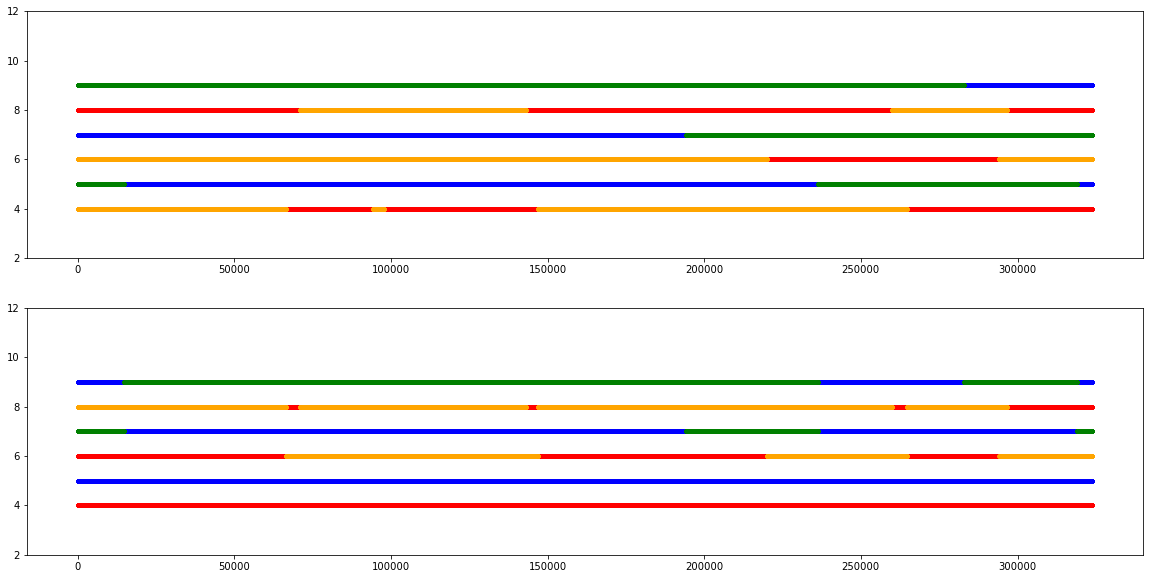

In [140]:
plt.figure(figsize=(20,10))

plt.subplot(2, 1, 1)
for i in range(2, m):
    plt.plot(2*i*X[i, 0, :], linestyle='None', marker='.', color='red')
    plt.plot(2*i*X[i, 1, :], linestyle='None', marker='.', color='orange')
    plt.plot(2*i*X[i, 2, :]+1, linestyle='None', marker='.', color='blue')
    plt.plot(2*i*X[i, 3, :]+1, linestyle='None', marker='.', color='green')
axes = plt.gca()
axes.set_ylim([2,(m+1)*2])

plt.subplot(2, 1, 2)
for i in range(2, m):
    plt.plot(2*i*X2[i, 0, :], linestyle='None', marker='.', color='red')
    plt.plot(2*i*X2[i, 1, :], linestyle='None', marker='.', color='orange')
    plt.plot(2*i*X2[i, 2, :]+1, linestyle='None', marker='.', color='blue')
    plt.plot(2*i*X2[i, 3, :]+1, linestyle='None', marker='.', color='green')   
axes = plt.gca()
axes.set_ylim([2,(m+1)*2])

plt.show()

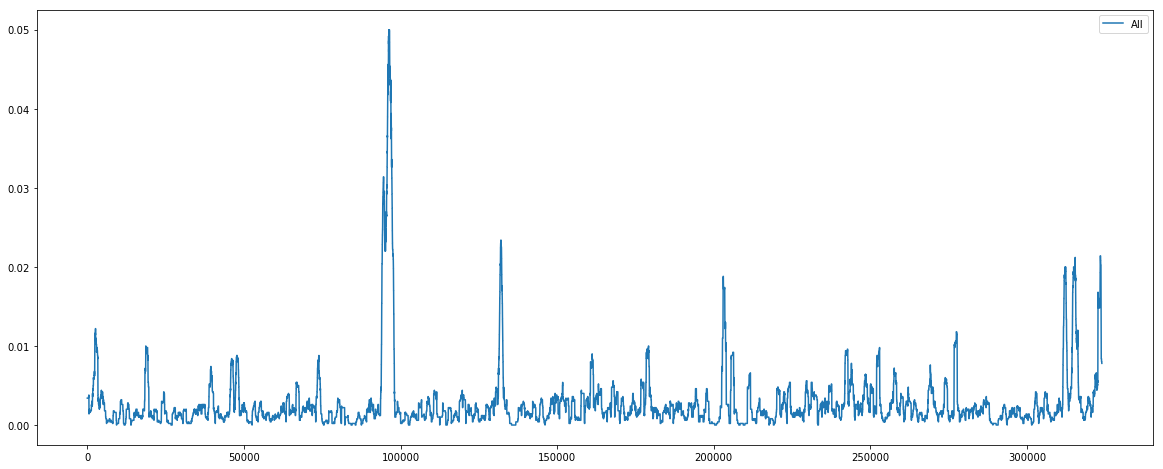

In [147]:
q = 1000
plt.figure(figsize=(20,8))

plt.subplot(1, 1, 1)
plt.plot(np.convolve(np.sum(diff, axis=0), np.ones((q,))/(m*q), mode='same'), label='All')
#plt.plot(np.convolve(np.sum(np.abs(to_genotype(X2, Y2)-family_data), axis=0)/m, np.ones((q,))/(m*q), mode='same'))

#for i in range(m):
#    plt.plot(np.convolve(np.abs(to_genotype(X, Y)-family_data)[i, :], np.ones((q,))/q, mode='same'), label=str(i)+'V')
#    #plt.plot(np.convolve(np.abs(to_genotype(X2, Y2)-family_data)[i, :], np.ones((q,))/q, mode='same'), label=str(i)+'H')

axes = plt.gca()
plt.legend()
plt.show()

In [91]:
print(np.sum(np.abs(to_genotype(X, Y)-family_data)))
print(np.sum(np.abs(to_genotype(X, Y)-family_data))/(m*n))

13030
0.00804688561442


In [85]:
for i in range(m):
    print(np.sum(np.abs(to_genotype(X, Y)-family_data)[i, :])/n)

0.00695996936872
0.00766708249447
0.00905660610402
0.00838037128071
0.00817039882415


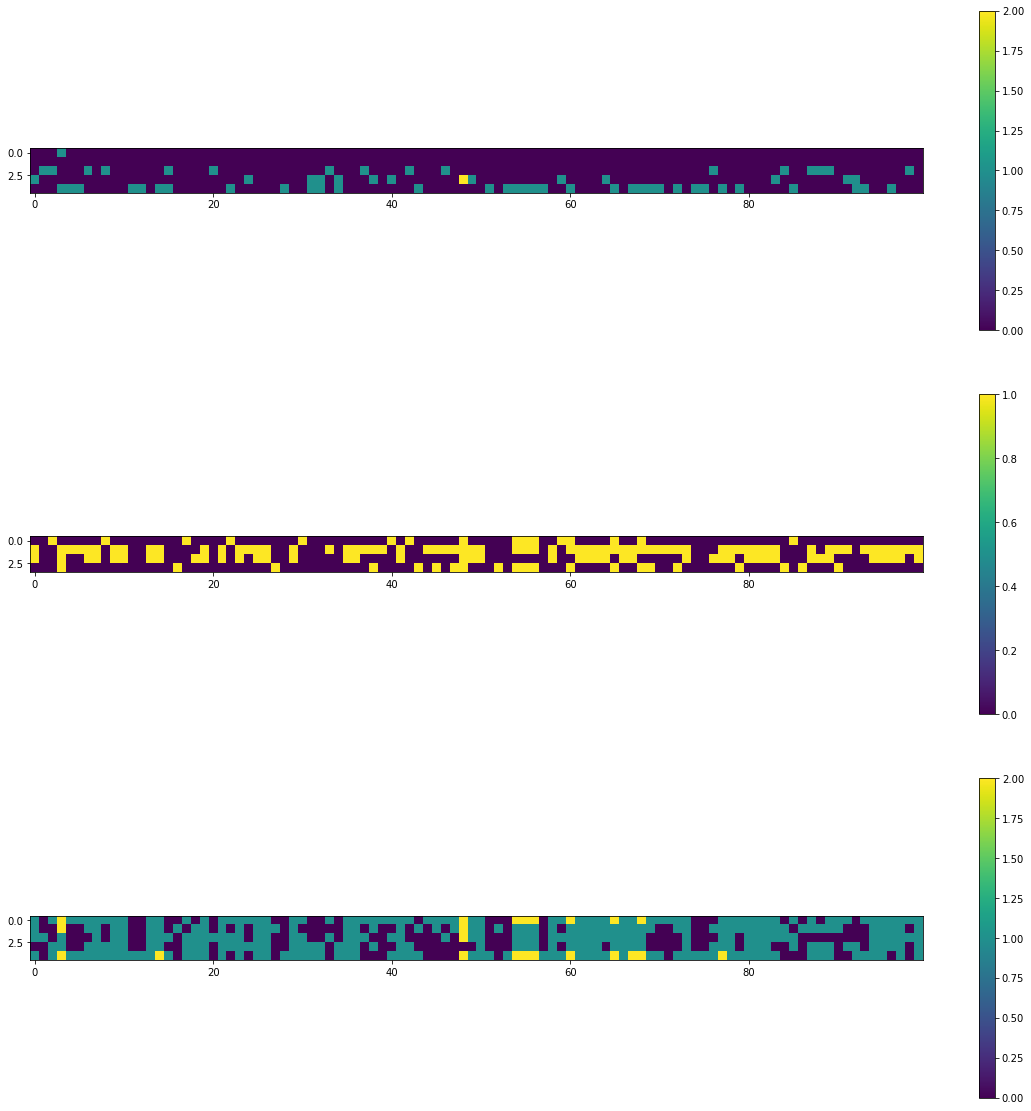

In [42]:
start, end = 1000, 1100
plt.figure(figsize=(20,20))
plt.subplot(3, 1, 1)
heatmap = plt.imshow(np.abs(to_genotype(X, Y)-family_data)[:, start:end])
plt.colorbar(heatmap)
plt.subplot(3, 1, 2)
heatmap = plt.imshow(Y[:, start:end])
plt.colorbar(heatmap)
plt.subplot(3, 1, 3)
heatmap = plt.imshow(family_data[:, start:end])
plt.colorbar(heatmap)
plt.show()

In [42]:
with np.load('raw_data/AU4237_AU4237202_AU4237201.MT.gen.ad.npz') as data:
    gen=data['gen']
    ad=data['ad'] 
    row_indices=data['row_indices']
    col_indices=data['col_indices']
    m=data['m']
    n=data['n']
    sample_ids=data['sample_ids']
print(gen.shape)
print(sample_ids)

(6, 34)
['AU4237202' 'AU4237201' 'AU4237301' 'AU4237302' 'AU4237303' 'AU4237304']


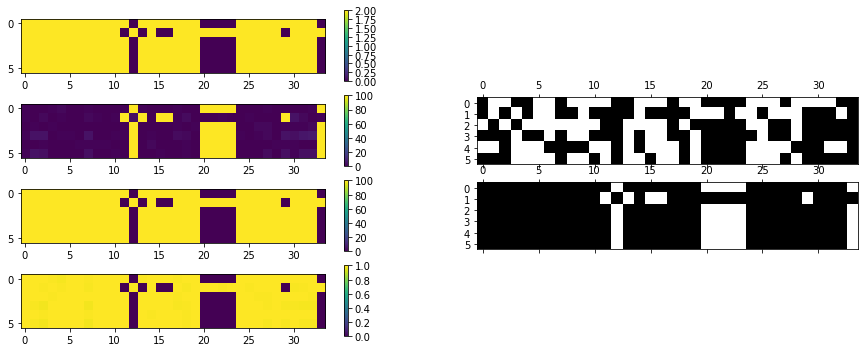

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

plt.subplot(4, 2, 1)
plt.imshow(gen)
plt.colorbar()

plt.subplot(4, 2, 3)
plt.imshow(ad[:, :, 0], vmax=100)
plt.colorbar()

plt.subplot(4, 2, 4)
plt.spy(ad[:, :, 0])

plt.subplot(4, 2, 5)
plt.imshow(ad[:, :, 1], vmax=100)
plt.colorbar()

plt.subplot(4, 2, 6)
plt.spy(ad[:, :, 1])

plt.subplot(4, 2, 7)
plt.imshow(ad[:, :, 1]/(ad[:, :, 0]+ad[:, :, 1]))
plt.colorbar()

plt.show()

In [36]:
print(m, n)
print(row_indices)
print(col_indices)

4610 3615
[909 910 911 912]
[   9   45   74  184  284  420  809  874 1286 1563 1742 3243 3607]


In [37]:
print(ad[:, 37, :])

IndexError: index 37 is out of bounds for axis 1 with size 13